## The purpose of this notebook is to study relationships between different entities within the transaction data through regression analysis.
 - in partticular, we want to answer the questions whether merchant grow their spending over time. 
 - for simplistic demonstration, we start by running regression on total spent over price, does total spent grow as price increases?
 - note that this may not be a good example of questions, because we have created some correlation already by computiing spent as multiplication of quantity and price price. 
 - a better question to ask is: do merchants increase their spent as their tenures increase? 

### setting up data and utility functions

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [2]:
def add_date_cols(baskets):
    baskets['datetime'] = pd.to_datetime(baskets['placed_at'])
    baskets['year'] = baskets["datetime"].dt.year
    baskets['month'] = baskets["datetime"].dt.month
    baskets['date'] = baskets["datetime"].dt.date
    baskets['day'] = baskets["datetime"].dt.day
    baskets['hour'] = baskets["datetime"].dt.hour
    baskets['weekday'] = baskets["datetime"].dt.weekday
    baskets['year_month'] = baskets["datetime"].apply(lambda t: t.strftime("%Y-%m"))
    baskets['month_num'] = (baskets['year'] - 2021) * 12 + baskets['month']
    baskets['year_week'] = baskets["datetime"].apply(lambda t: t.strftime("%Y-%W")) # this makes the beginning of Jan 2022 as week 2022-00 , not 2022-52
    baskets['week_num'] = baskets["datetime"].apply(lambda t: int(t.strftime("%W"))) 
    baskets['iso_week_num'] = baskets["datetime"].dt.isocalendar().week # this returns week number 52 for Jan 1, 2021, not 0 which is what we want
    baskets['cum_week_num'] = (baskets['year'] - 2021) * 52 + baskets['week_num']
    return baskets
def get_merchant_attributes(baskets):
    merchant_attributes = baskets.groupby(['merchant_id']).agg(
        total_spent = ('spent', 'sum'), 
        num_orders = ('order_id', 'nunique'), 
        first_month = ('month_num', 'min'), 
        last_month = ('month_num', 'max'), 
        num_months = ('month_num', 'nunique'), 
        num_weeks = ('week_num', 'nunique'), 
        num_days = ('date', 'nunique'), 
        num_skus = ('sku_id','nunique'), 
        num_top_cats = ('top_cat','nunique'), 
        num_sub_cats = ('sub_cat','nunique'),
    ).reset_index()
    merchant_attributes['avg_spent_per_order'] = merchant_attributes.total_spent / merchant_attributes.num_orders
    merchant_attributes['tenure_month'] = merchant_attributes.last_month - merchant_attributes.first_month +1
    return merchant_attributes

### preparing the analysis table
 - unit of study is SKU, so we may want to start with a table for SKU attributes, each row for one SKU


In [3]:
def get_sku_attributes(baskets):
    sku_attributes = baskets.groupby(['sku_id']).agg(
        total_spent = ('spent', 'sum'), 
        num_orders = ('order_id', 'nunique'), 
        num_merchants = ('merchant_id', 'nunique'), 
        first_month = ('month_num', 'min'), 
        last_month = ('month_num', 'max'), 
        num_months = ('month_num', 'nunique'), 
        first_week = ('week_num', 'min'), 
        last_week = ('week_num', 'max'), 
        num_weeks = ('week_num', 'nunique'), 
        num_days = ('date', 'nunique'), 
    ).reset_index()
    sku_attributes['avg_spent_per_order'] = sku_attributes.total_spent / sku_attributes.num_orders
    sku_attributes['tenure_month'] = sku_attributes.last_month - sku_attributes.first_month +1
    return sku_attributes

 - the values of study are price and spent, but we don't want just one average price and one total spent for the SKU over all times
 - we want to study the changes in spent over price, we want to keep some dimension for variances in the analysis table
 - we can start with price and spent on each week over all merchants: then we want to compute the average price for the week and total spent by the week, for all merchants

In [4]:
def get_skus_by_week(baskets):
    skus_by_week = baskets.groupby(['sku_id','year_week']).agg(
        avg_price_by_week = ('price','mean'),
        num_order_by_week = ('order_id', 'nunique'), 
        num_merchants_by_week = ('merchant_id', 'nunique'),
        total_spent_by_week = ('spent', 'sum'),
    ).reset_index()
    return skus_by_week

In [5]:
filename = './AwanTunai_transaction_data.csv'
baskets = pd.read_csv(filename)
baskets["spent"] = baskets["qty"] * baskets["price"] # column wide multiplication
baskets = add_date_cols(baskets)
merchant_attributes = get_merchant_attributes(baskets)

In [6]:
sku_week = get_skus_by_week(baskets)

In [7]:
sku_week.describe()

,sku_id,avg_price_by_week,num_order_by_week,num_merchants_by_week,total_spent_by_week
count,54344.000000,5.434400e+04,54344.000000,54344.000000,5.434400e+04
mean,1100.121467,1.155972e+05,9.061350,5.560614,1.561432e+06
std,426.431588,3.116036e+05,20.265732,8.749830,6.147552e+06
min,1.000000,1.331019e+02,1.000000,1.000000,1.000000e+03
25%,816.000000,1.450000e+04,2.000000,1.000000,9.950000e+04
50%,1125.000000,4.100000e+04,4.000000,3.000000,2.700000e+05
75%,1453.000000,1.220000e+05,8.000000,6.000000,8.052500e+05
max,1860.000000,4.240000e+06,349.000000,133.000000,1.264344e+08


In [8]:
sku_attributes = get_sku_attributes(baskets)
top_skus = sku_attributes.sort_values(by="num_orders",ascending=False)[["sku_id"]]
top_skus.head(20)

,sku_id
1503,1504
866,867
1512,1513
873,874
971,972
984,985
970,971
991,992
1337,1338
972,973


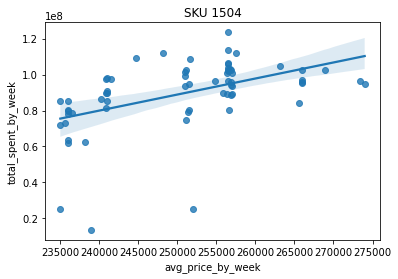

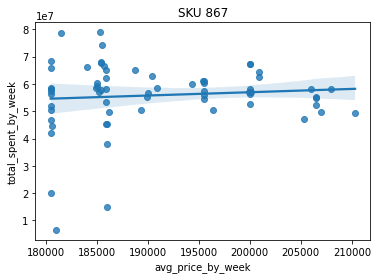

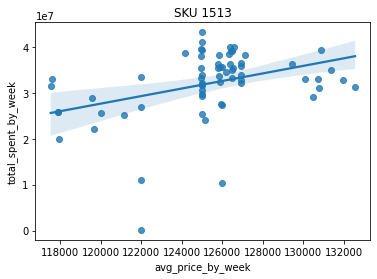

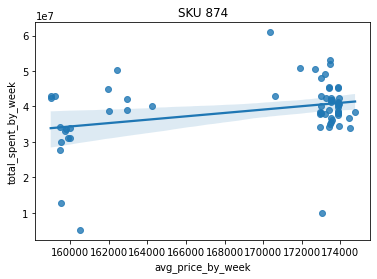

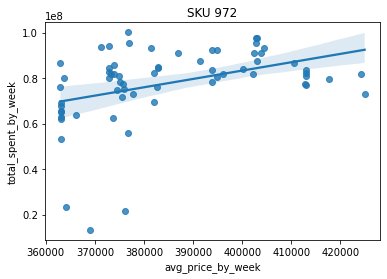

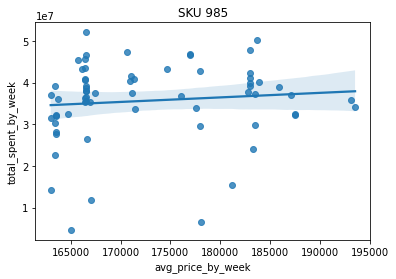

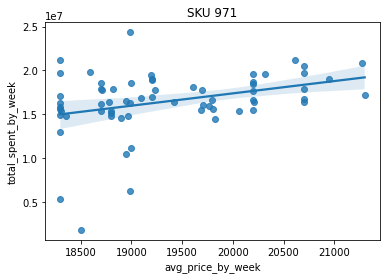

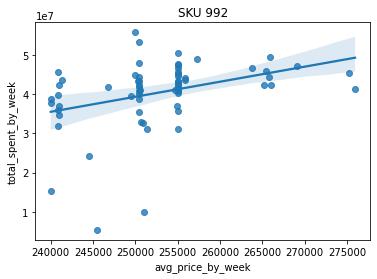

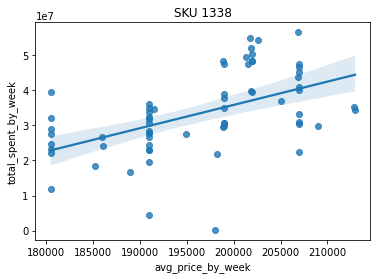

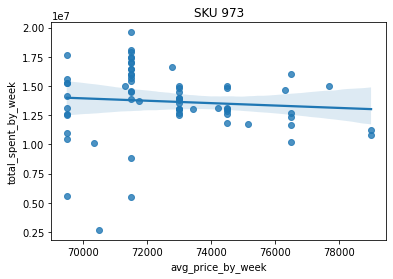

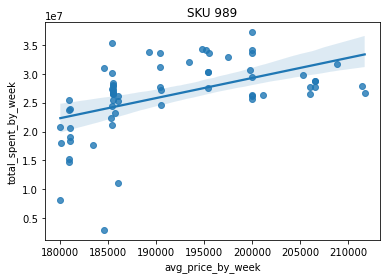

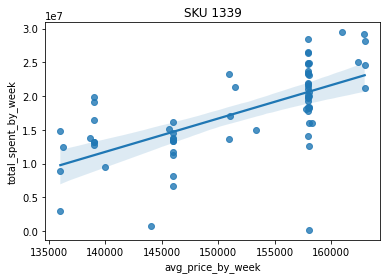

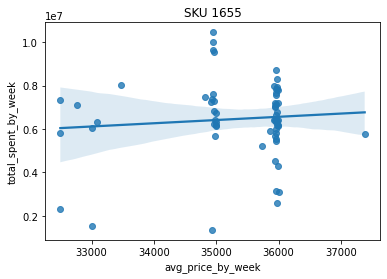

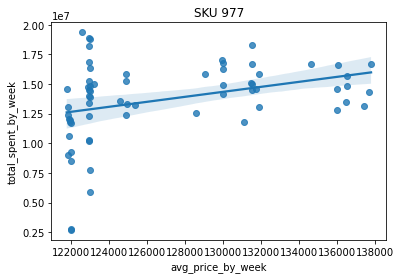

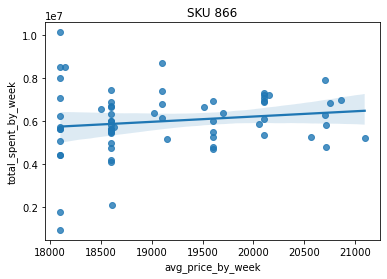

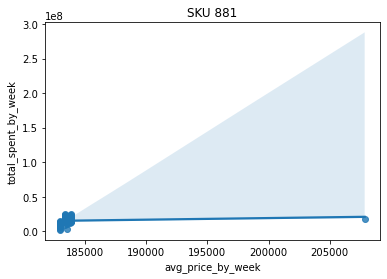

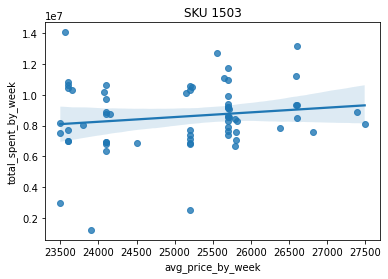

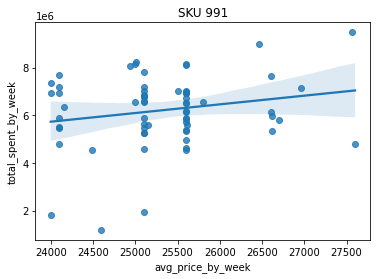

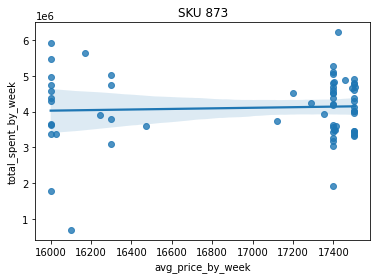

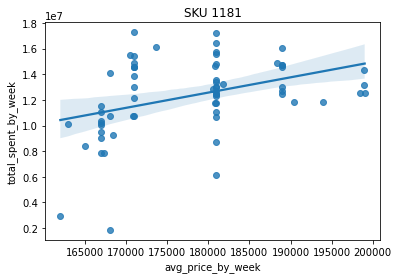

In [9]:
sku_attributes = get_sku_attributes(baskets)
top_skus = sku_attributes.sort_values(by="num_orders",ascending=False)[["sku_id"]]

for sku_id in top_skus[:20].sku_id:
    plt.figure(sku_id)
    sns.regplot(data = sku_week[sku_week["sku_id"] ==sku_id], x="avg_price_by_week",y="total_spent_by_week").set(title = "SKU " + str(sku_id))

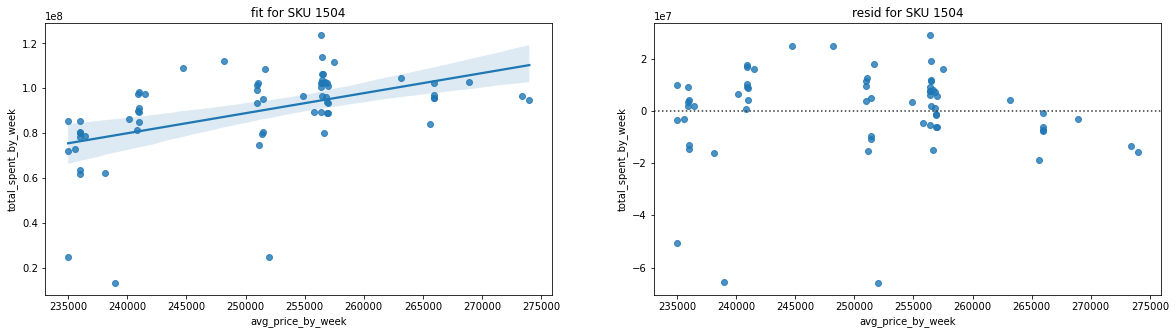

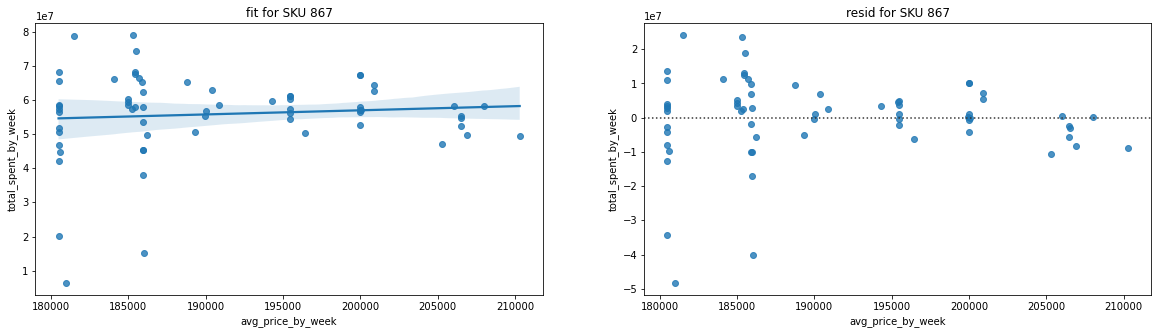

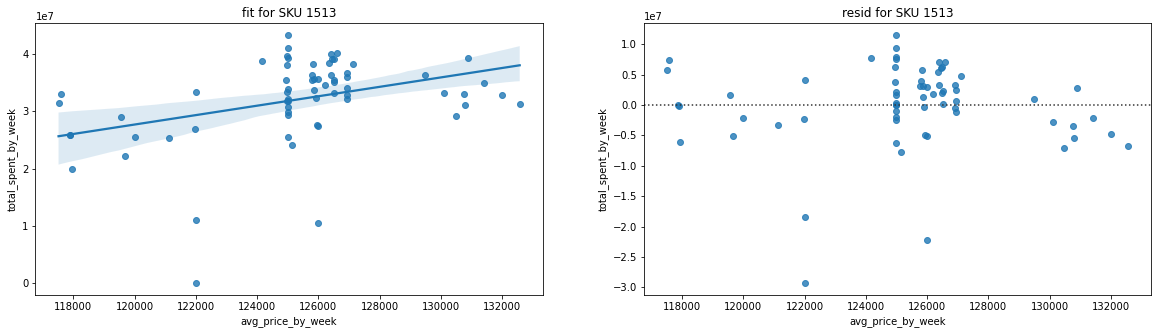

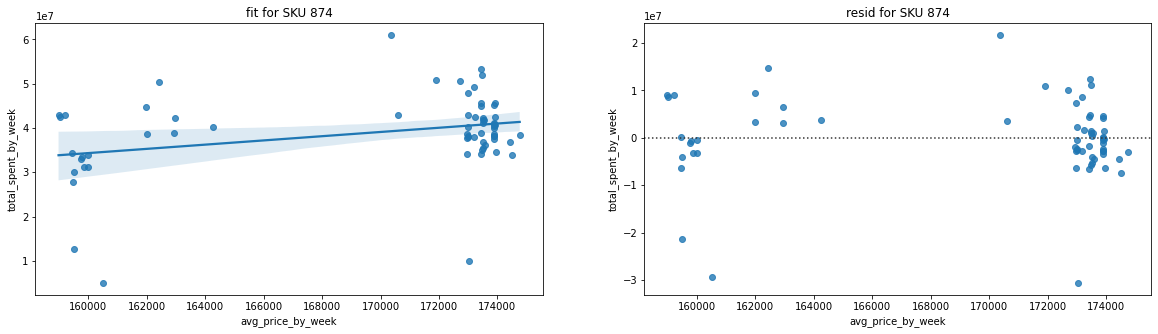

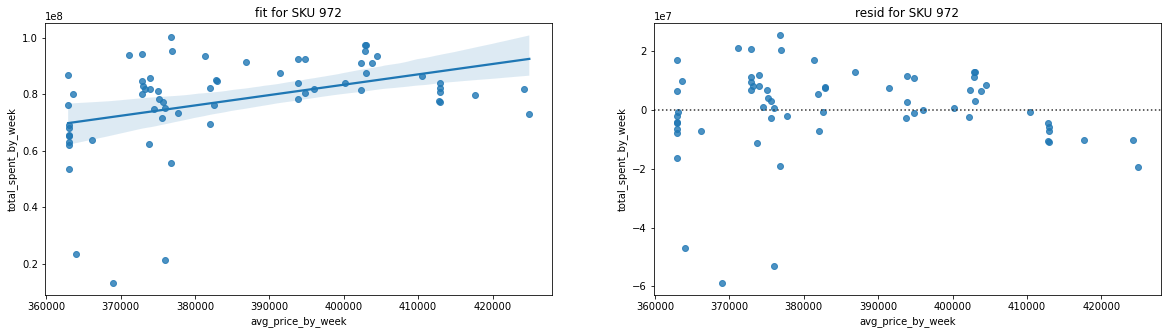

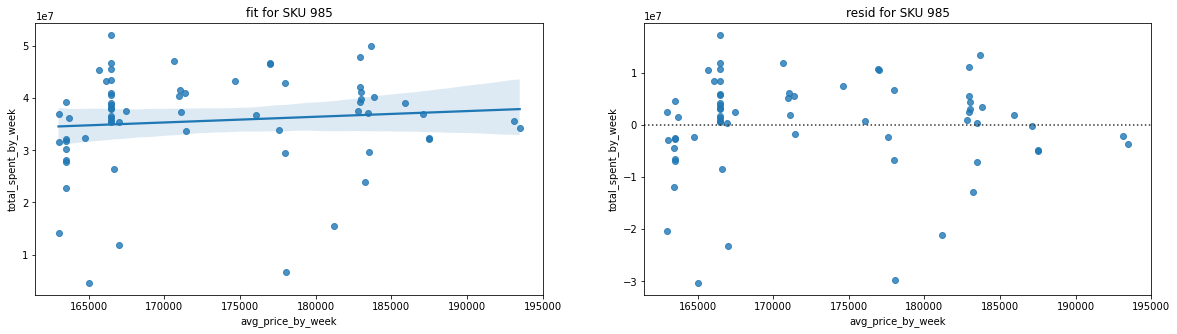

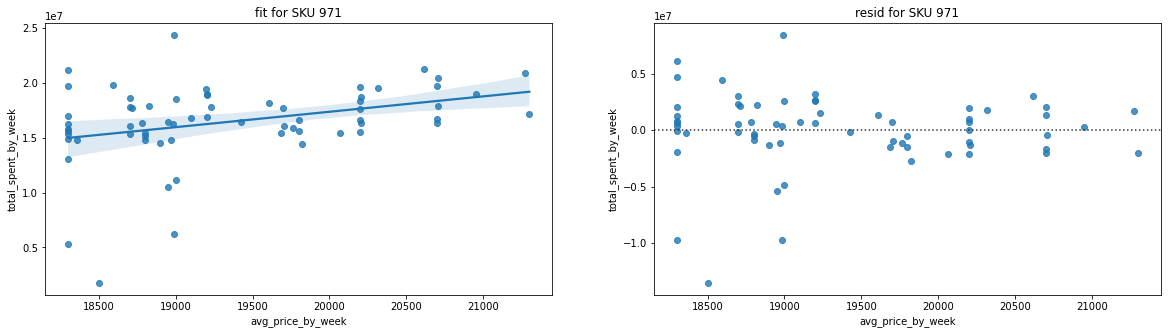

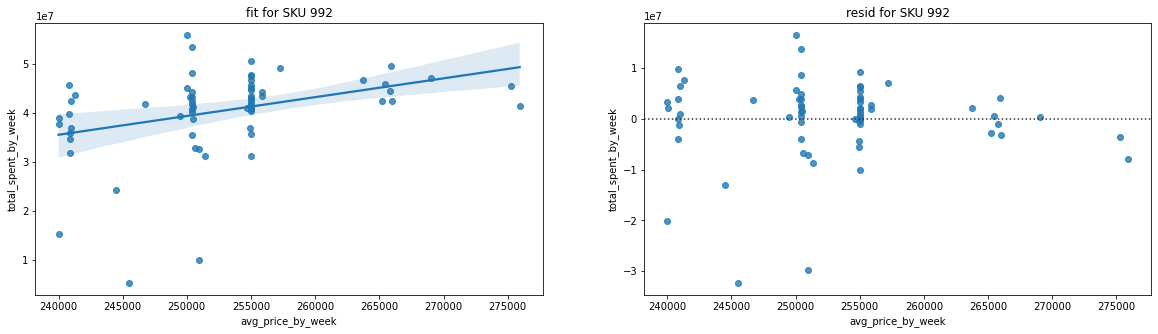

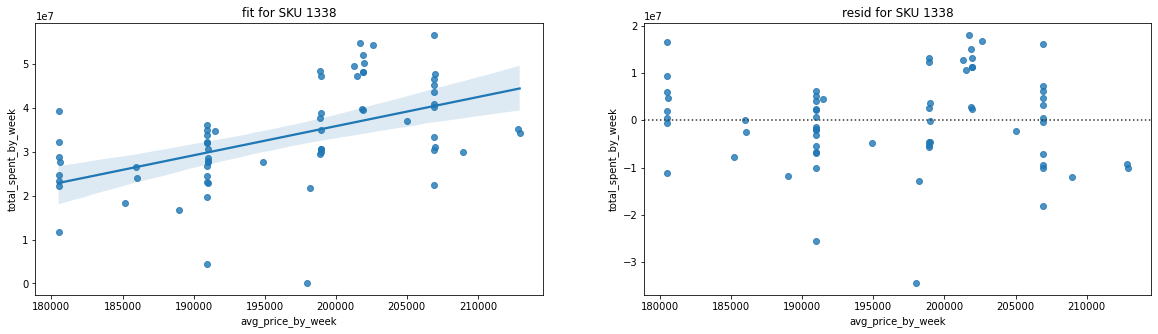

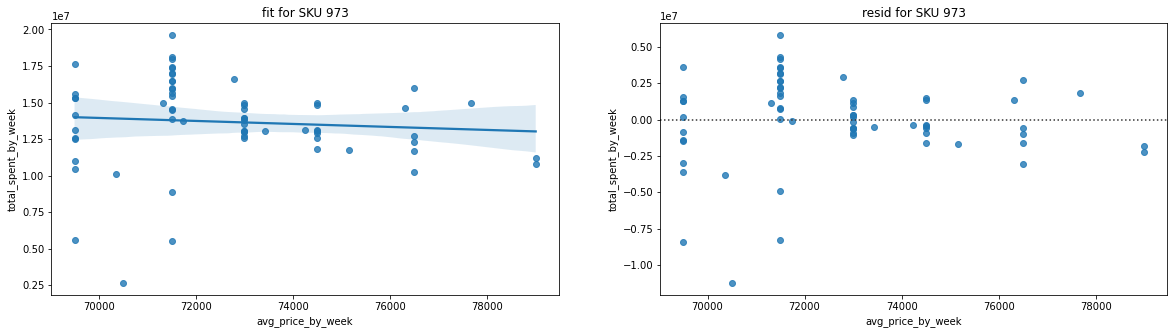

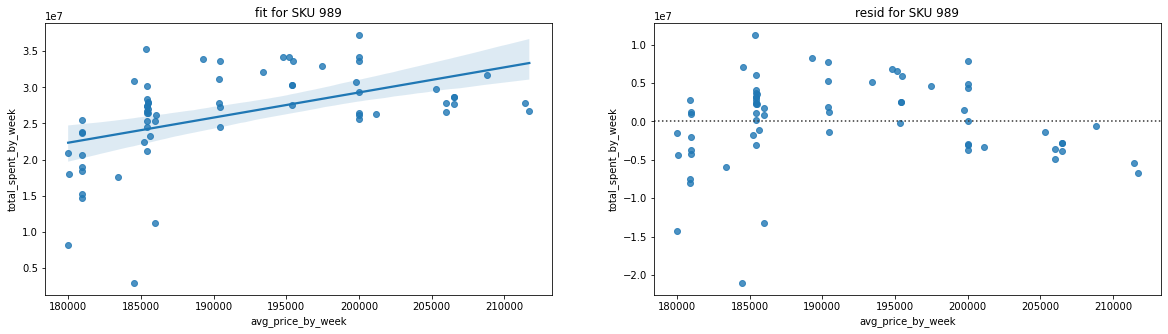

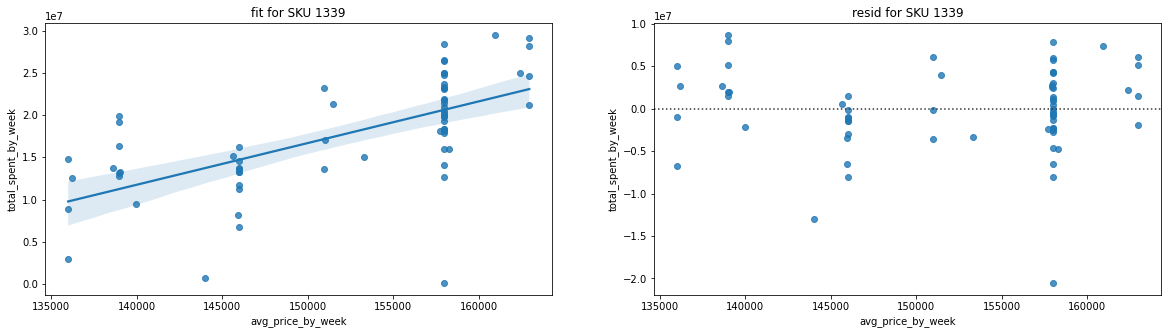

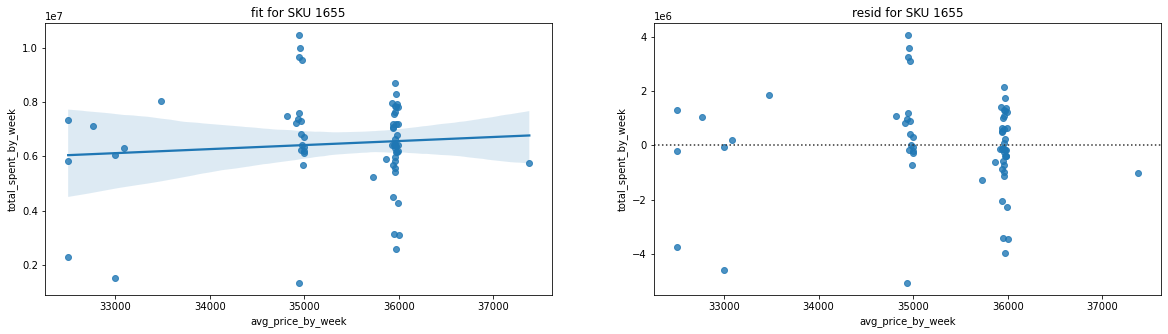

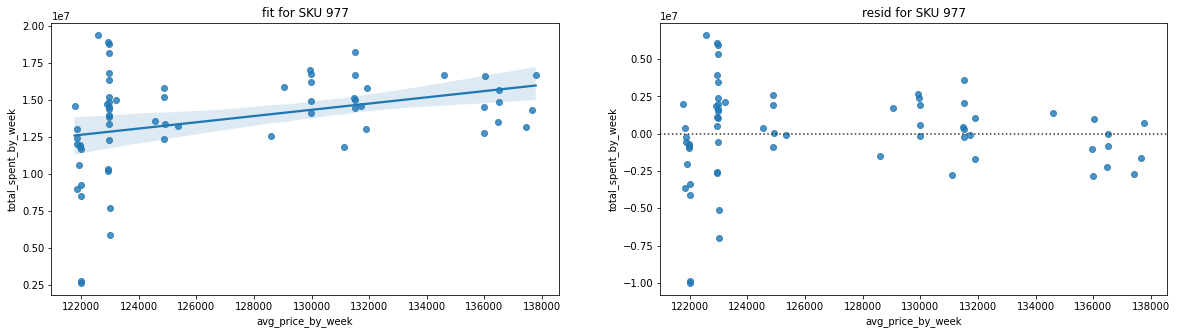

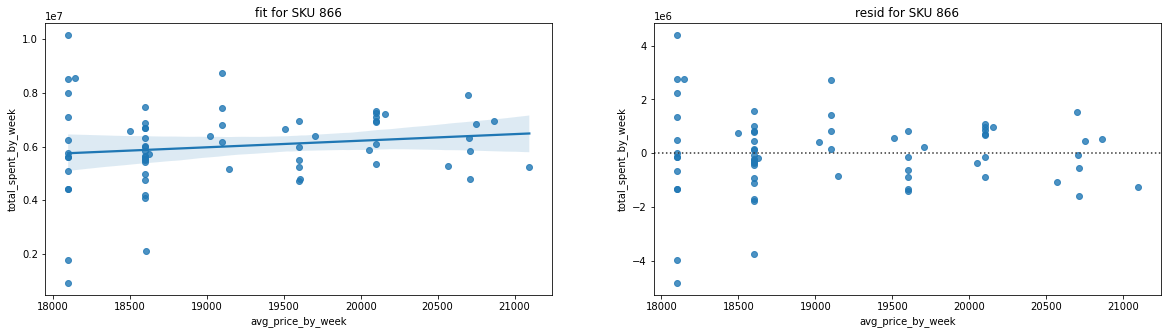

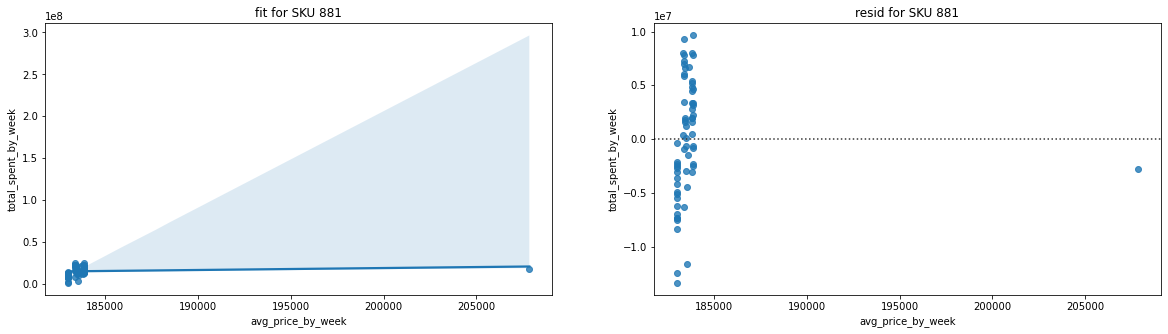

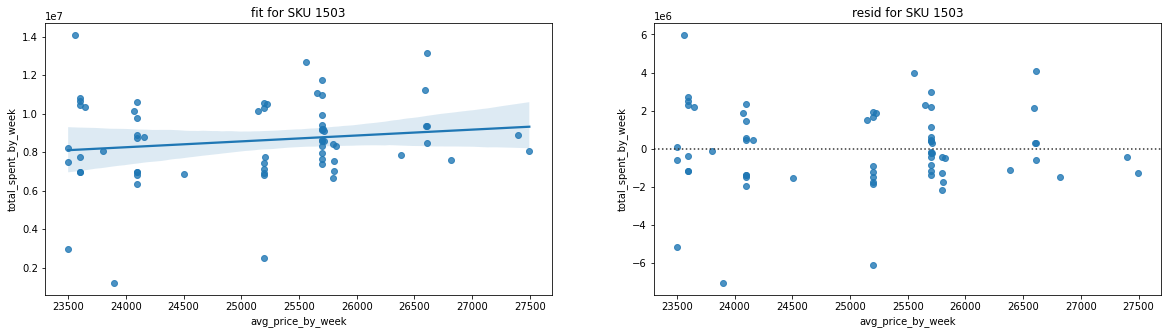

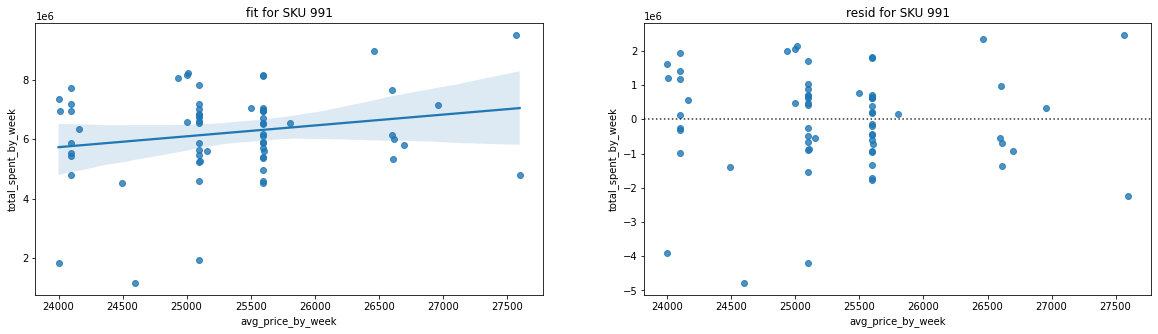

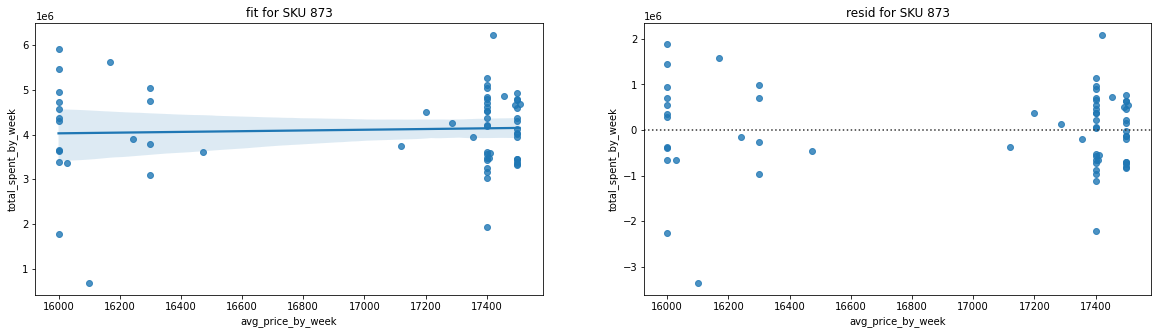

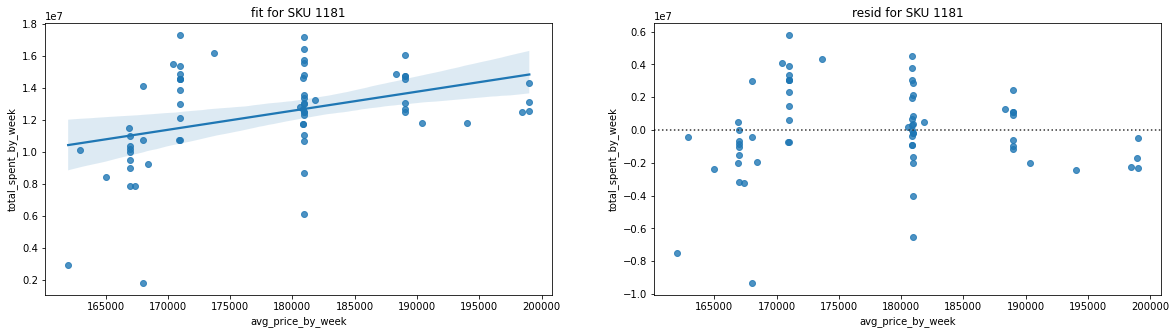

In [10]:
sku_attributes = get_sku_attributes(baskets)
top_skus = sku_attributes.sort_values(by="num_orders",ascending=False)[["sku_id"]]

for sku_id in top_skus[:20].sku_id:
    #plt.figure(sku_id)
    f, axes = plt.subplots(1, 2, figsize = (20,5))
    sns.regplot(data = sku_week[sku_week["sku_id"] ==sku_id], x="avg_price_by_week",y="total_spent_by_week", ax=axes[0])
    sns.residplot(data = sku_week[sku_week["sku_id"] ==sku_id], x="avg_price_by_week",y="total_spent_by_week",ax=axes[1])
    axes[0].set(title = "fit for SKU " + str(sku_id))
    axes[1].set(title = "resid for SKU " + str(sku_id))
